Считаем данные

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error

data = pd.read_csv('spx.csv')

Разделите данные на `train` и `test`, так, чтобы в `train` оказались данные до `2018` года включительно.

In [ ]:
data.index = pd.to_datetime(data["Date"])
data = data.drop(["Date"], axis=1)
data

,spx_ret
Date,
1994-01-06,NaN
1994-01-07,0.595136
1994-01-10,1.142795
1994-01-11,-0.239860
1994-01-12,0.008438
...,...
2019-08-26,1.098299
2019-08-27,-0.320318
2019-08-28,0.654548


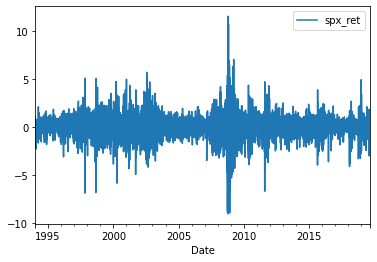

In [ ]:
data.plot()

In [ ]:
train = data.loc[:"2018-12-31"]
test = data.loc["2019-01-01":]

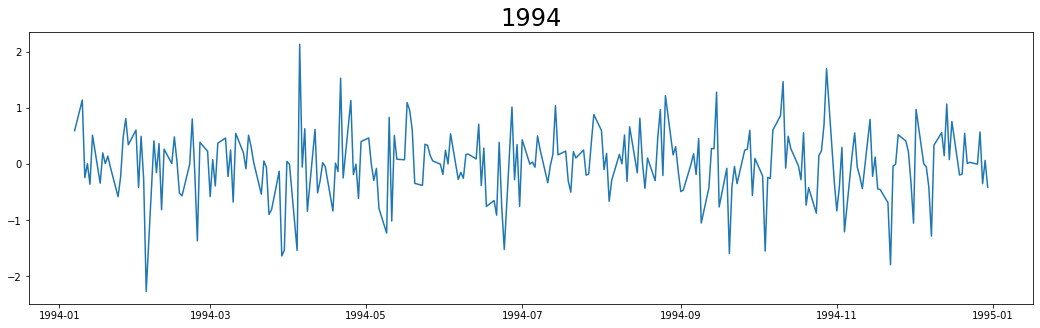

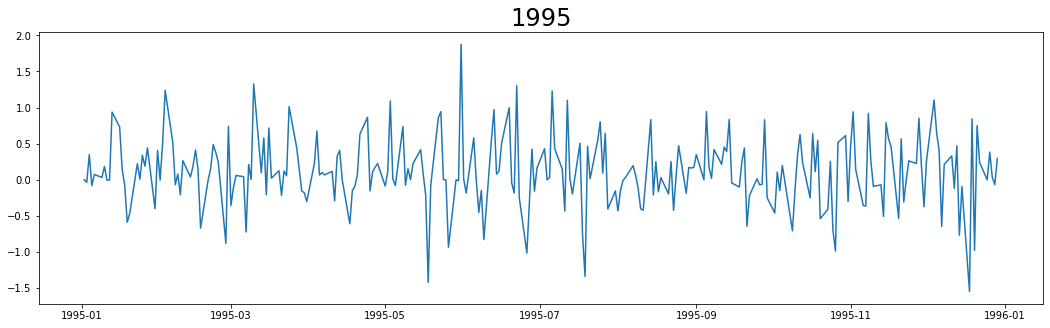

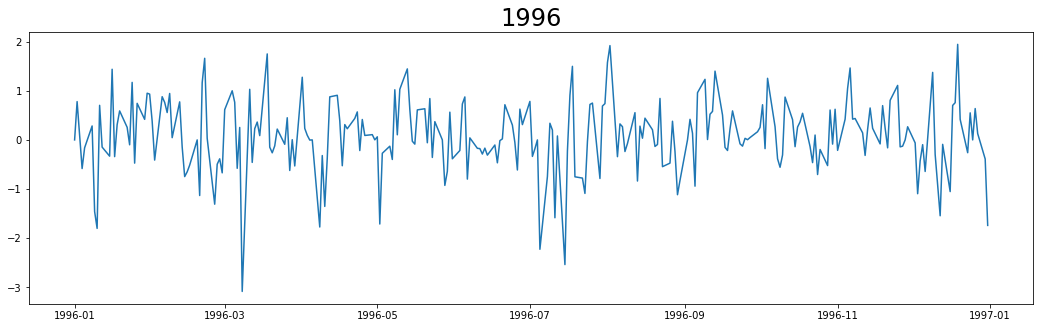

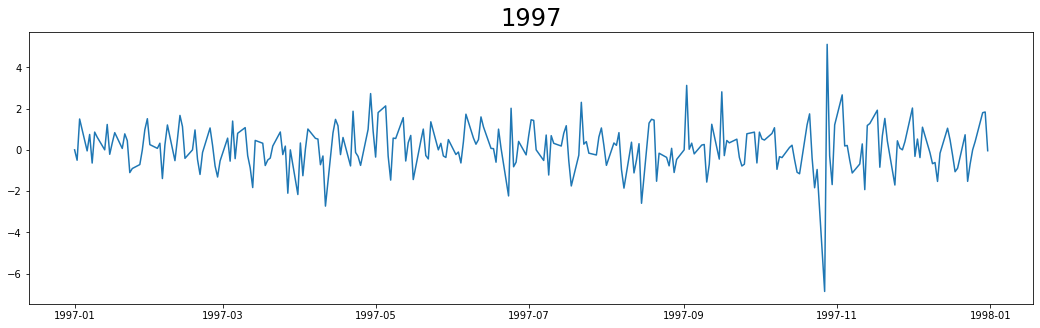

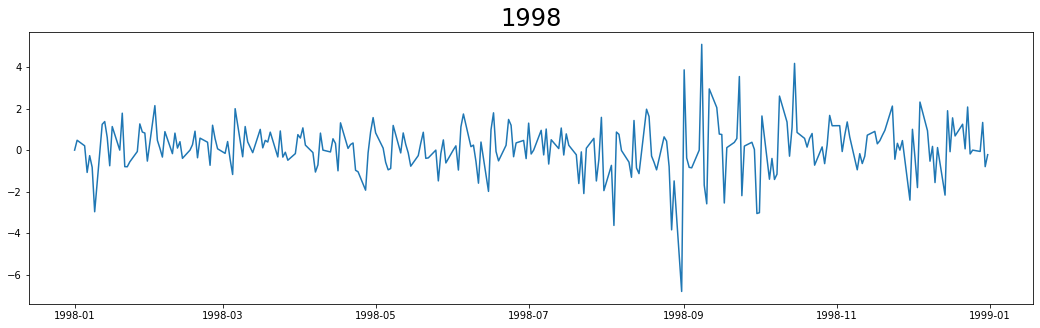

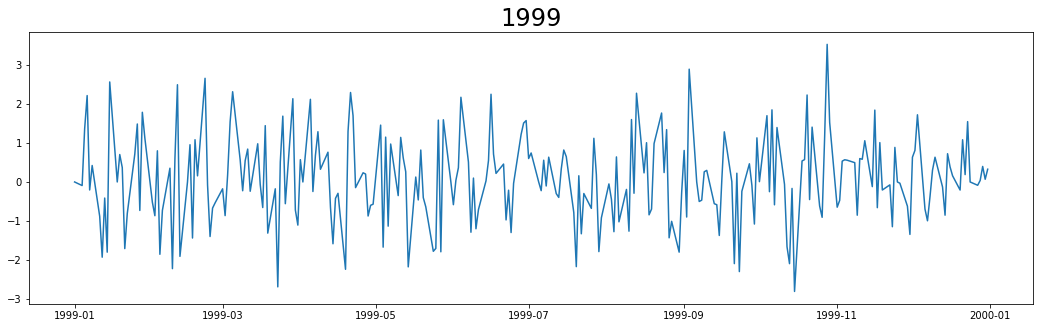

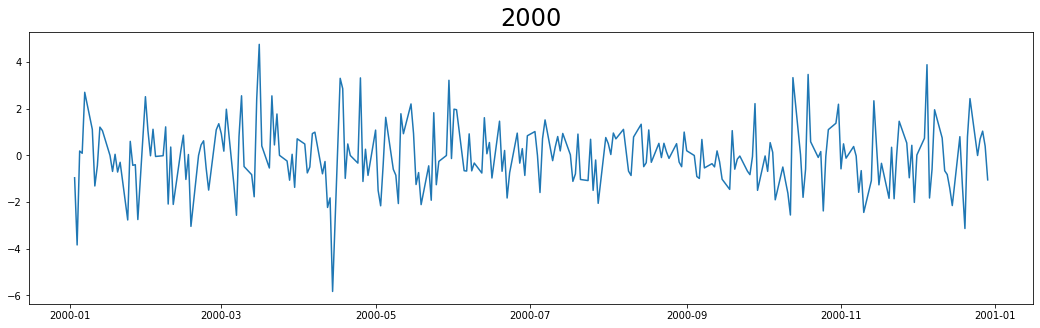

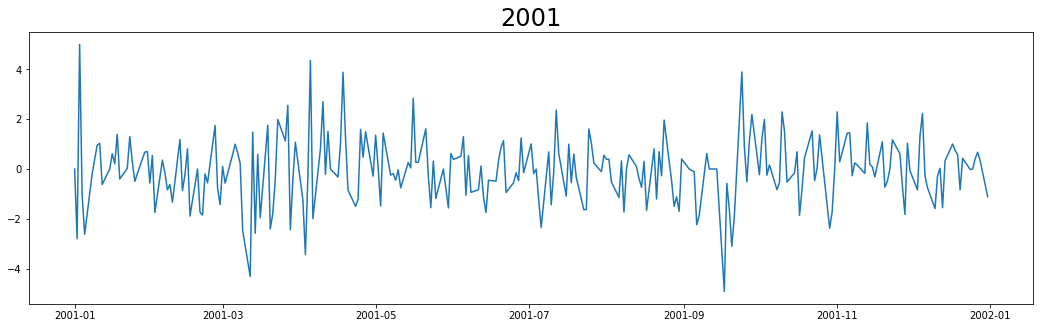

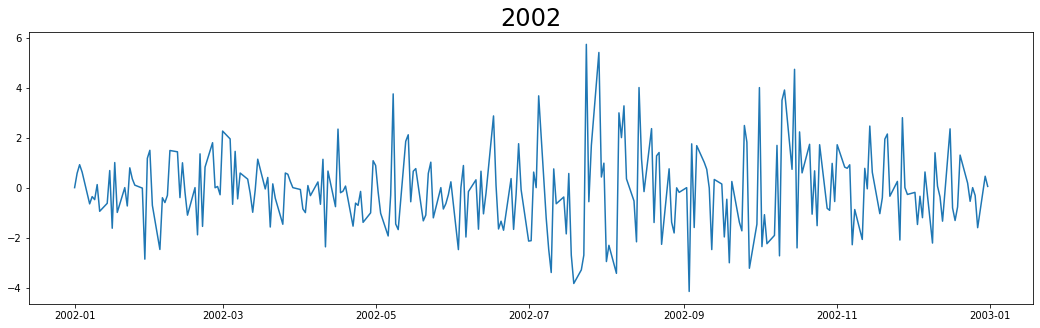

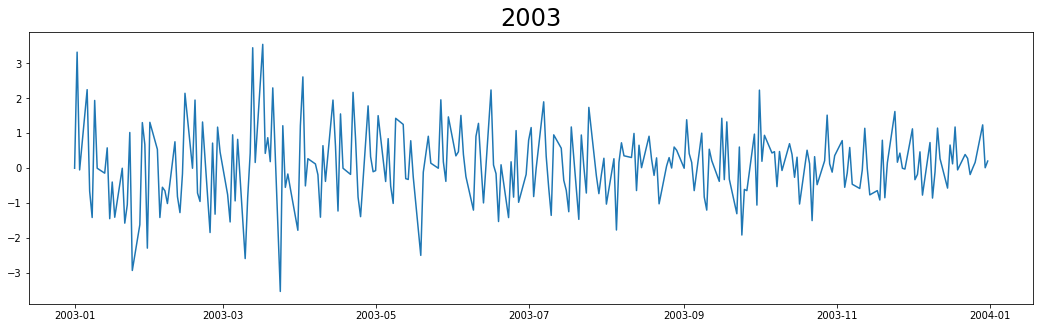

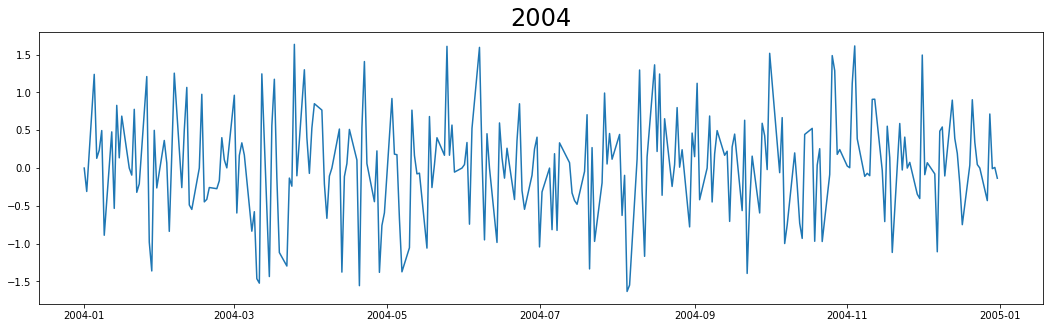

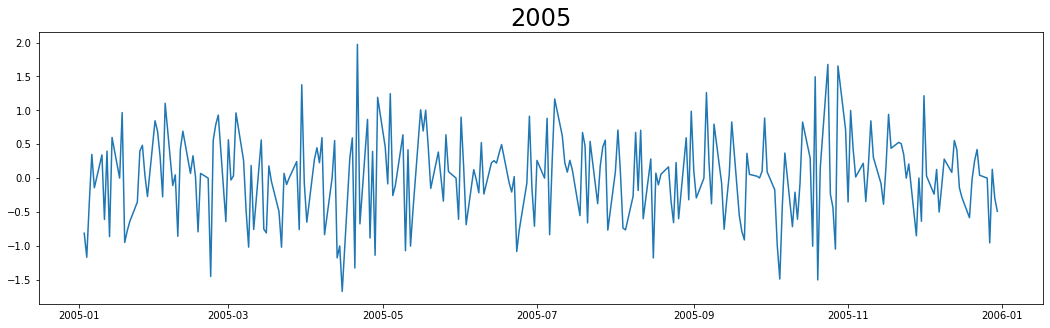

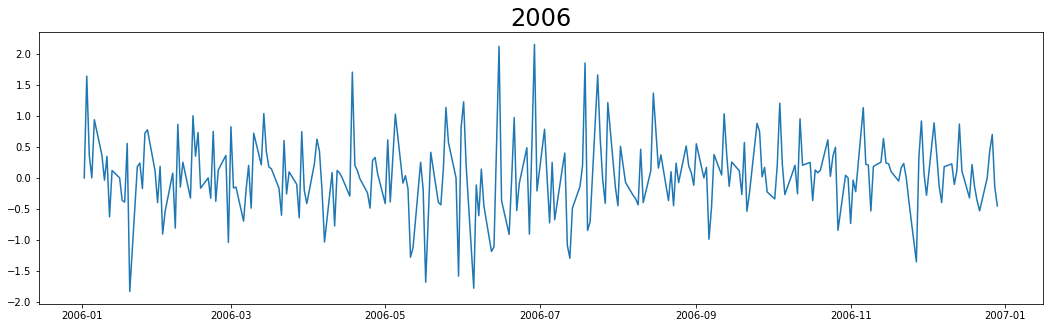

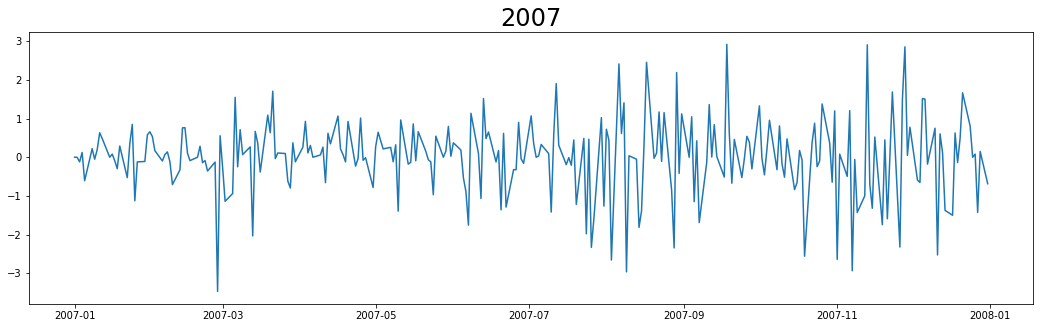

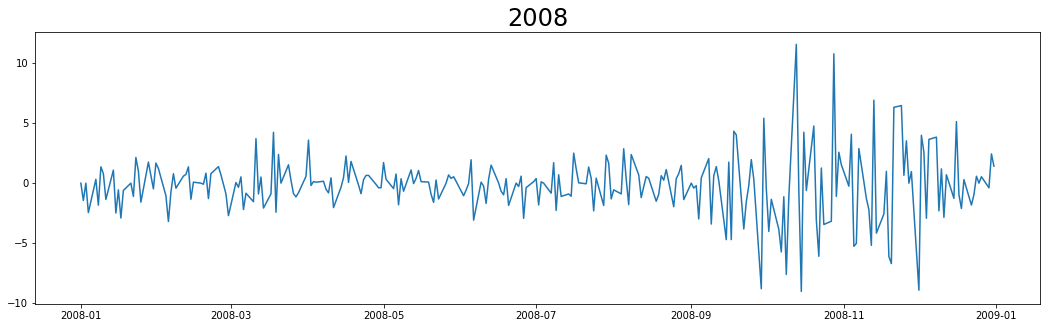

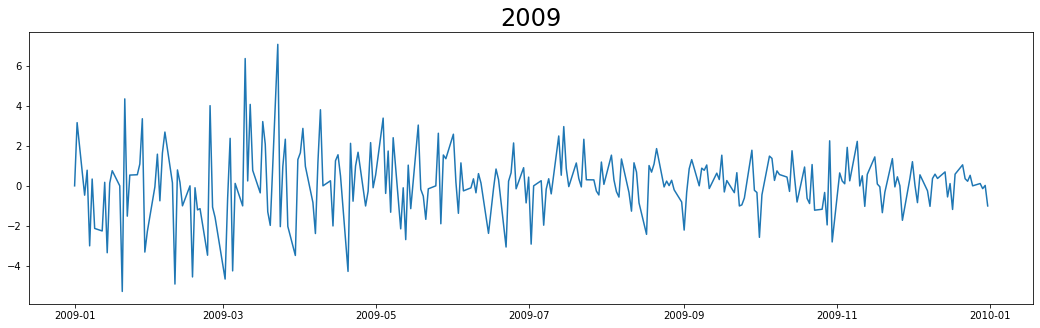

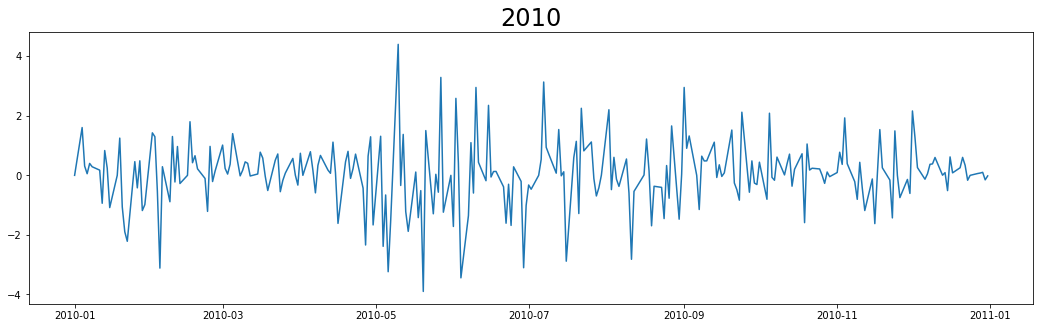

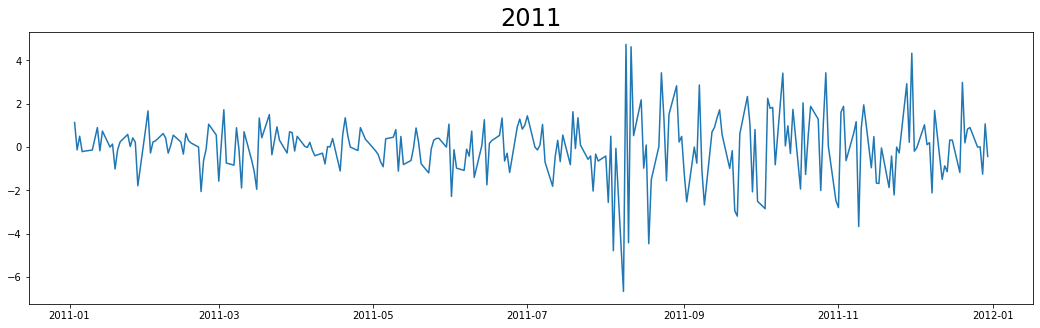

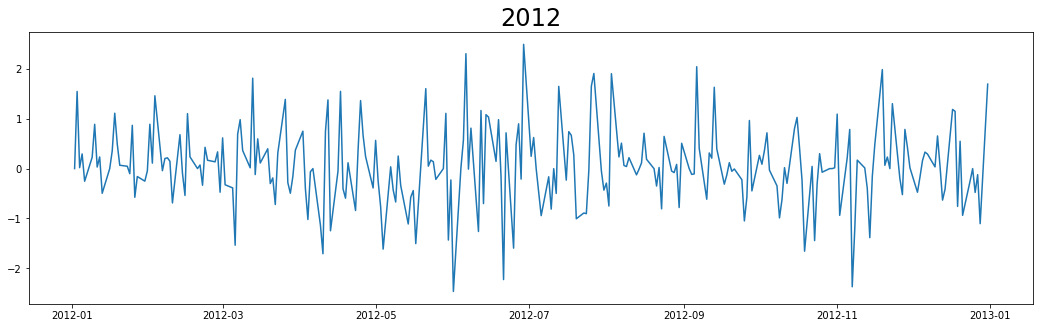

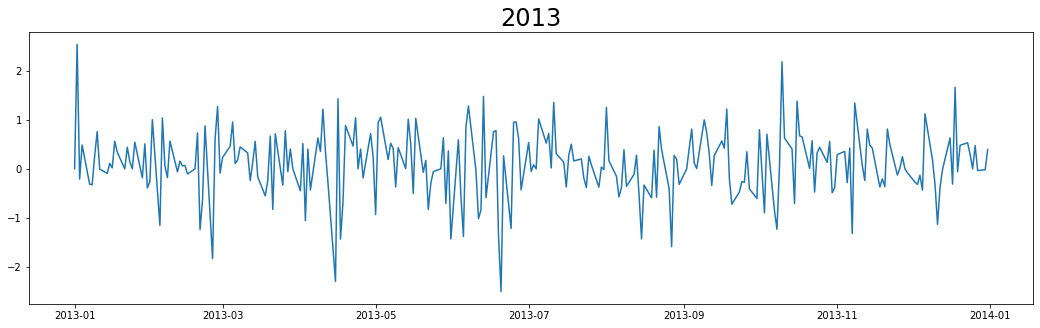

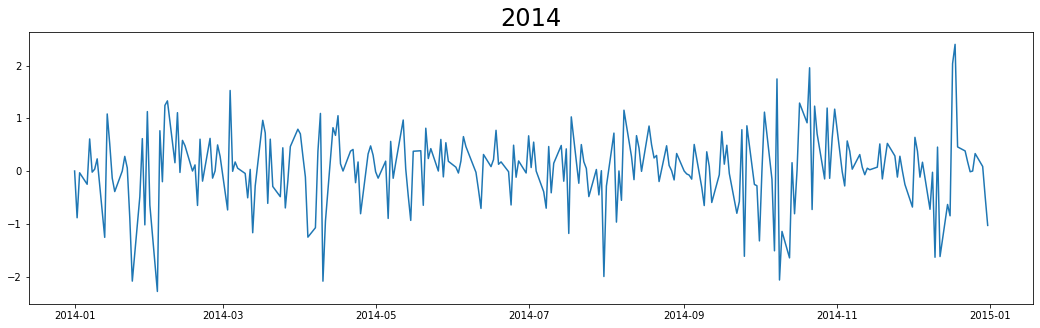

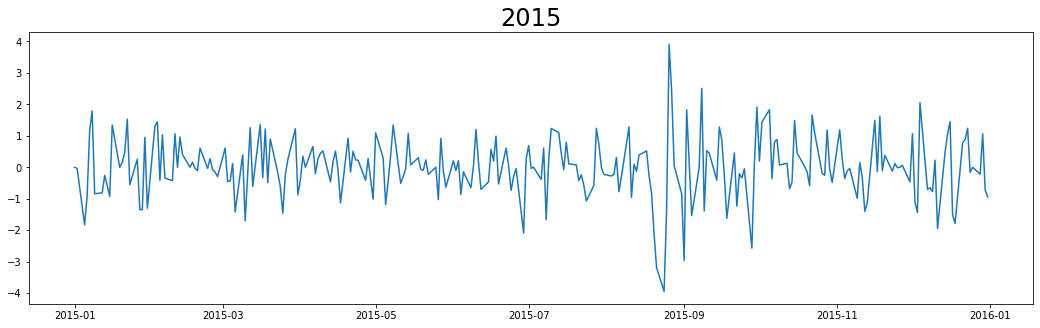

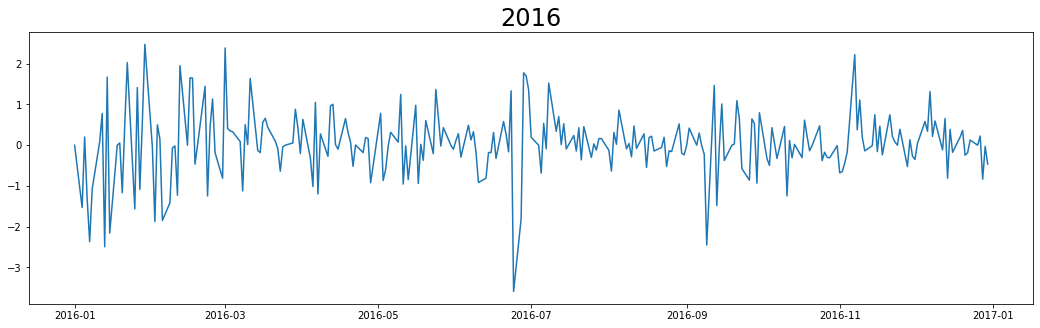

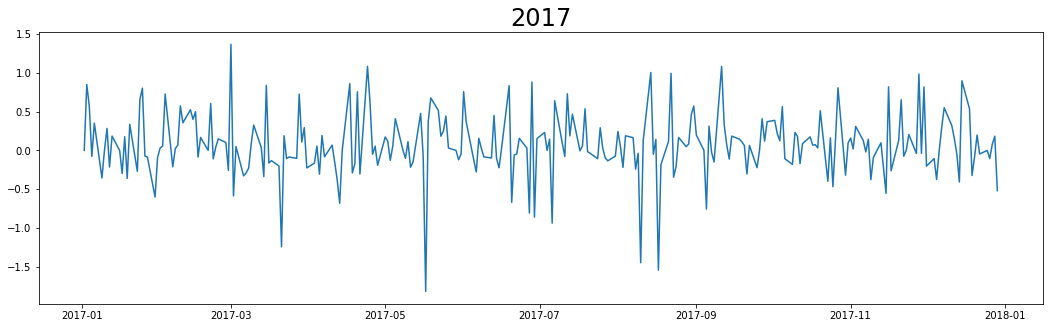

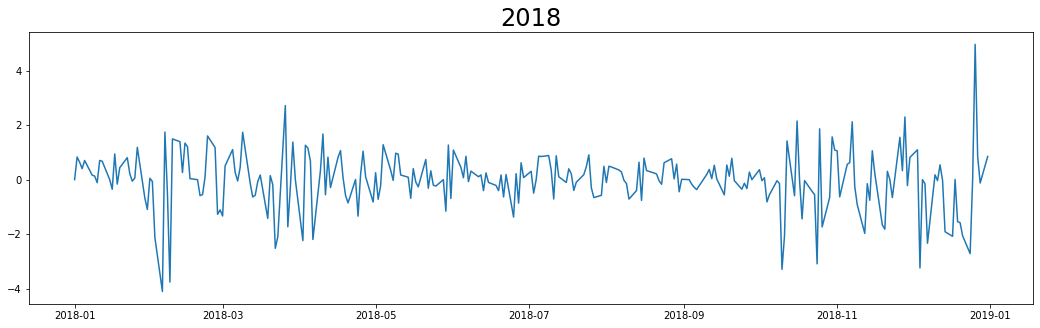

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5

for year in set(train.index.year):
    plt.plot(train[["spx_ret"]].loc[train.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

Судя по графику, датасет состоит из последовательных процентных изменений индекса S&P 500

In [ ]:
train["Year"] = train.index.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


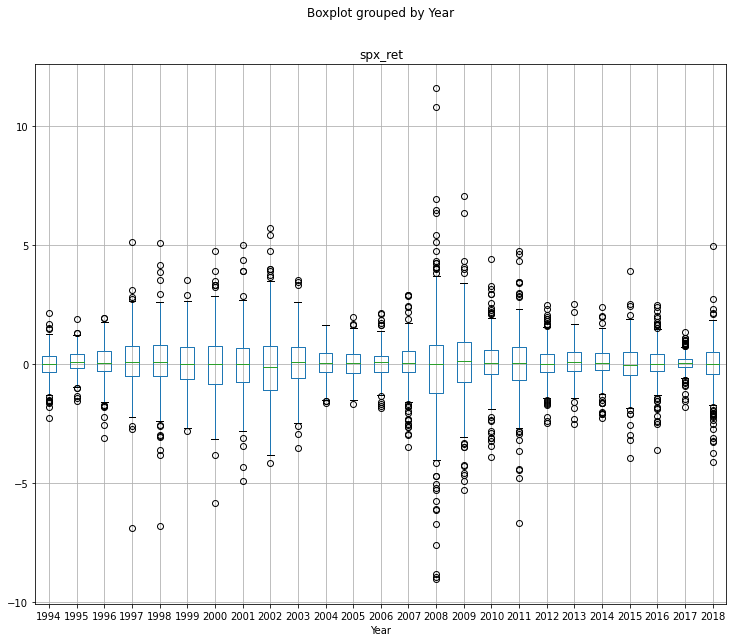

In [ ]:
plt.rcParams["figure.figsize"] = 12, 10

train.boxplot(by ='Year', column =['spx_ret'])

plt.show()

Обучите `ARMA`-модель с оптимальными гиперпараметрами. Постройте ее предсказания и `95`-процентный доверительный интервал для них. 

Что вы можете сказать о полученной модели?

Проверим стационарность ряда с помощью KPSS test и Augmented Dickey–Fuller test

In [ ]:
kpss(train["spx_ret"][1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.13030239047479023,
 0.1,
 35,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [ ]:
adfuller(train["spx_ret"][1:])

(-14.443752446321227,
 7.286951578522241e-27,
 34,
 6482,
 {'1%': -3.431359239667287,
  '10%': -2.5670074010110926,
  '5%': -2.8619859972456685},
 19945.163948739726)

Построим PACF и ACF для нахождения гиперпараметров

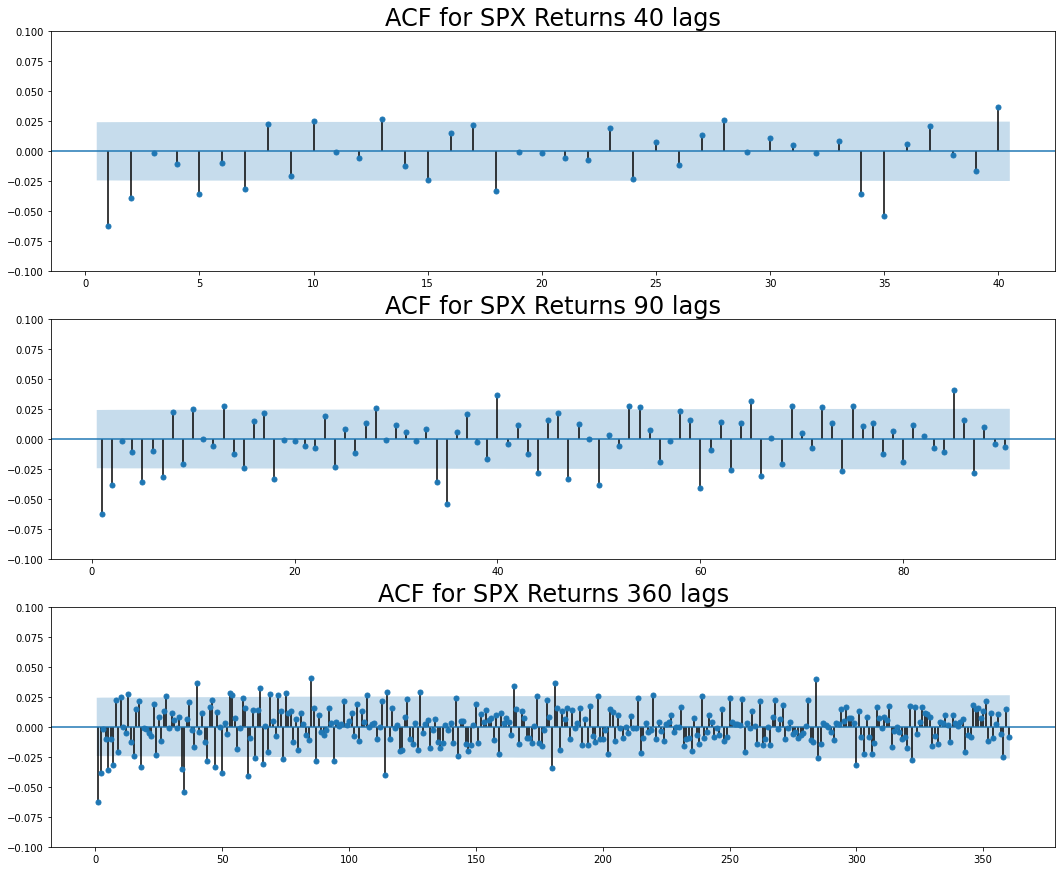

In [ ]:
plt.rcParams["figure.figsize"] = 18, 15

fig, axes = plt.subplots(3, 1)

sgt.plot_acf(train.spx_ret[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_acf(train.spx_ret[1:], zero = False, lags = 90, ax = axes[1])
sgt.plot_acf(train.spx_ret[1:], zero = False, lags = 360, ax = axes[2])

axes[0].set_title("ACF for SPX Returns 40 lags", size = 24)
axes[1].set_title("ACF for SPX Returns 90 lags", size = 24)
axes[2].set_title("ACF for SPX Returns 360 lags", size = 24)

axes[0].set_ylim([-0.1, 0.1])
axes[1].set_ylim([-0.1, 0.1])
axes[2].set_ylim([-0.1, 0.1])

plt.show()

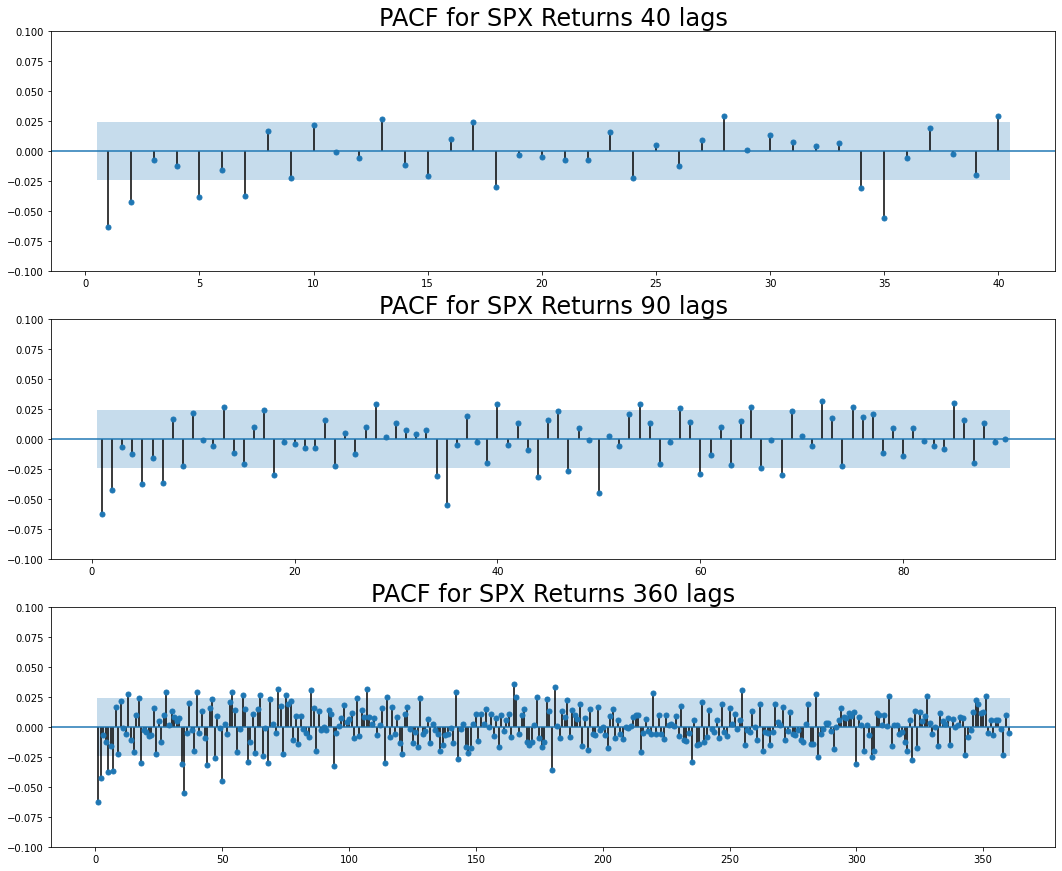

In [ ]:
plt.rcParams["figure.figsize"] = 18, 15

fig, axes = plt.subplots(3, 1)

sgt.plot_pacf(train.spx_ret[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train.spx_ret[1:], zero = False, lags = 90, ax = axes[1])
sgt.plot_pacf(train.spx_ret[1:], zero = False, lags = 360, ax = axes[2])

axes[0].set_title("PACF for SPX Returns 40 lags", size = 24)
axes[1].set_title("PACF for SPX Returns 90 lags", size = 24)
axes[2].set_title("PACF for SPX Returns 360 lags", size = 24)

axes[0].set_ylim([-0.1, 0.1])
axes[1].set_ylim([-0.1, 0.1])
axes[2].set_ylim([-0.1, 0.1])

plt.show()

Нет необходимости в дифференцировании => d = 0

Из графиков ACF и PACF => $p=1,2$, $q=1,2$

Индекс имеет недельную сезонность (5 дней) $P=1, Q=1, M=5$

In [ ]:
def fit_seasonal_model(train_data, params, seasonal_params, 
                           verbose = False, plot_pred = False, plot_resid = False, 
                           start_date = "2019-01-01", end_date = "2019-08-30"):
    
    model = SARIMAX(train_data, order = params, seasonal_order = seasonal_params)
    model_results = model.fit()
    
    if verbose == True:
        print(model_results.summary())
    
    if plot_pred == True:
        pred = model_results.predict(start=start_date, end=end_date)
        
        plt.rcParams["figure.figsize"] = 18, 5
        data["spx_ret"][start_date:end_date].plot()
        pred[start_date:end_date].plot()
        plt.show()
    
    if plot_resid == True:
        plt.rcParams["figure.figsize"] = 18, 5

        fig, axes = plt.subplots(1, 2)

        sgt.plot_acf(model_results.resid[1:], zero = False, lags = 40, ax = axes[0])
        sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40, ax = axes[1])

        plt.show()
    
    return model_results

In [ ]:
model = SARIMAX(train["spx_ret"][1:], order = (1, 0, 1))
model_results = model.fit()
model_results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                spx_ret   No. Observations:                 6517
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10024.948
Date:                Tue, 12 Apr 2022   AIC                          20055.897
Time:                        10:26:45   BIC                          20076.243
Sample:                    01-07-1994   HQIC                         20062.933
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.047     13.689      0.000       0.554       0.739
ma.L1         -0.7075      0.043    -16.560      0.000      -0.791      -0.624
sigma2         1.2696      0.010    128.105      0.000       1.250       1.289
===================================================================================
Ljung-Box (Q):                       96.77   Jarque-Bera (JB):             20322.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start_date, end_date = test.index[0], test.index[-1]

In [ ]:
forecast = model_results.get_forecast(len(test.index))
predictions_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
predictions_df["Predictions"] = model_results.predict(start = start_date, end = end_date)

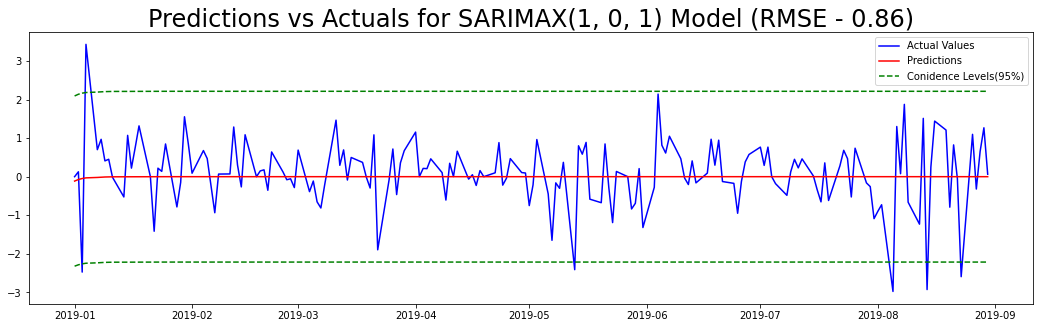

In [ ]:
rmse = np.sqrt(mean_squared_error(test["spx_ret"].values, predictions_df["Predictions"]))

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test["spx_ret"][start_date:end_date], color = "blue", label = "Actual Values")

plt.plot(predictions_df["Predictions"][start_date:end_date], color = "red", label = "Predictions")
plt.plot(predictions_df["upper spx_ret"][start_date:end_date], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(predictions_df["lower spx_ret"][start_date:end_date], color = "green", linestyle = "--")

plt.title(f"Predictions vs Actuals for SARIMAX(1, 0, 1) Model (RMSE - {round(rmse, 2)})", size = 24)

plt.legend()
plt.show()

Модель дает прогноз близкий к нулю, что является малоинформативным

Посмотрите на остатки модели. Что вы можете сказать о них? Имеет ли смысл применять `GARCH` для их предсказания и почему?

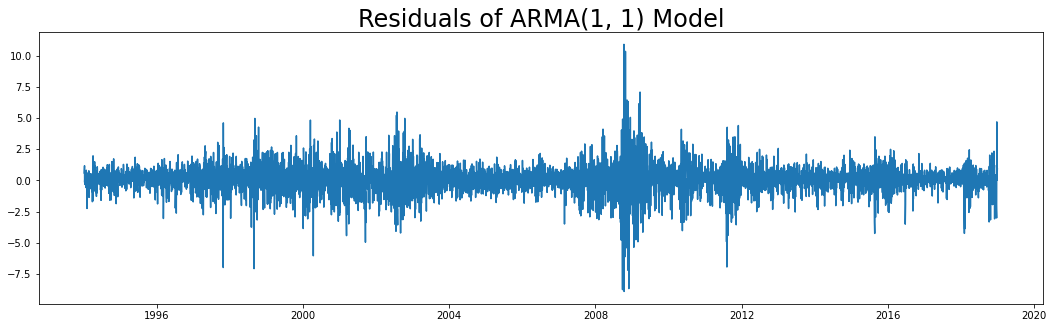

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Обучите `GARCH` на остатках модели.

Может пользоваться реализацией модели из `from arch import arch_model`.

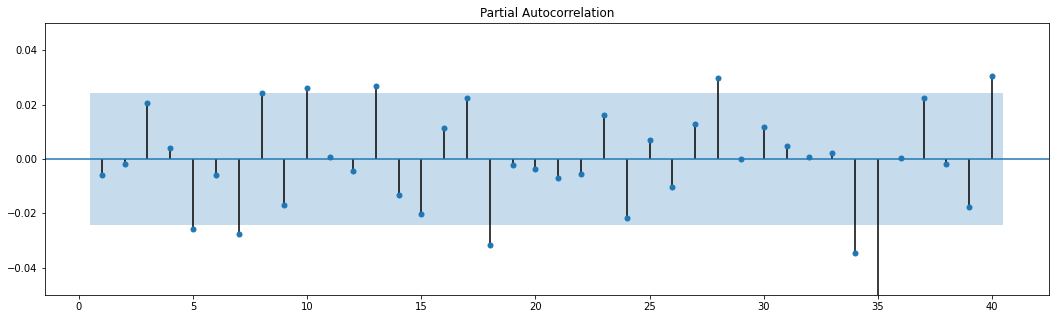

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5

sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40)
ax = plt.gca()
ax.set_ylim([-0.05, 0.05])
plt.show()

In [ ]:
resid_df = data.copy()
resid_df["spx_ret_resid"] = resid_df["spx_ret"].shift(1).loc[resid_df.index]
resid_df.at[train.index[1]:train.index[-1], "spx_ret_resid"] = model_results.resid

In [ ]:
!pip install arch

     |████████████████████████████████| 902 kB 13.9 MB/s 
     |████████████████████████████████| 9.8 MB 58.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from arch import arch_model

Посмотрите на коэффициенты модели с помощью `.summary()`. Что вы можете сказать о ней?

In [ ]:
resid_model = arch_model(resid_df["spx_ret_resid"][1:], p = 2, q = 2, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test.index[0], update_freq = 5)
resid_model_results.summary()

Iteration:      5,   Func. Count:     53,   Neg. LLF: 8624.406419457919
Iteration:     10,   Func. Count:    100,   Neg. LLF: 8621.036823486345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8620.971400093407
            Iterations: 14
            Function evaluations: 133
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          spx_ret_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8620.97
Distribution:                  Normal   AIC:                           17253.9
Method:            Maximum Likelihood   BIC:                           17294.6
                                        No. Observations:                 6517
Date:                Tue, Apr 12 2022   Df Residuals:                     6516
Time:                        10:38:32   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0761  9.927e-03      7.665  1.794e-14 [5.663e-02,9.555e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0255  6.713e-03      3.806  1.415e-04 [1.239e-02,3.870e-02]
alpha[1]       0.0587  1.611e-02      3.643  2.695e-04 [2.711e-02,9.024e-02]
alpha[2]       0.0987  2.147e-02      4.596  4.299e-06   [5.661e-02,  0.141]
beta[1]        0.3051      0.139      2.190  2.852e-02   [3.205e-02,  0.578]
beta[2]        0.5174      0.129      4.026  5.671e-05     [  0.266,  0.769]
============================================================================

Covariance estimator: robust
"""

In [ ]:
resid_forecasts = resid_model_results.forecast().residual_variance.loc[test.index].values

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


Постройте доверительный интервал для предсказания `spx`, комбинируя обученные выше модели. Что вы можете сказать о нем?

In [ ]:
arma_garch_predictions_df = predictions_df.copy()
arma_garch_predictions_df["lower spx_ret"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper spx_ret"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)

[]

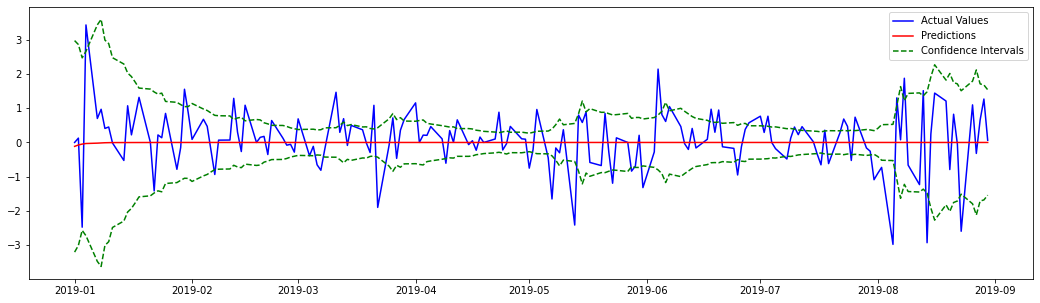

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test["spx_ret"], color = "blue", label = "Actual Values")

plt.plot(arma_garch_predictions_df["Predictions"][test.index], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower spx_ret"][test.index], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper spx_ret"][test.index], color = "green", linestyle = "--")

plt.legend()
plt.plot()

Доверительный интервал достаточно точно отображает историю изменения индекса S&P 500